# Biweekly Report 6

# Jake Watts

# Supervised Depth Estimation 2

In this section of the report I train and test a U-Net model on the DIODE data again, however this time I use a pre-trained DenseNet for the encoder to see if it helps to improve model performance.

My guess is that using a pre-trained model for the encoder will help improve the performance of the model.

In [ ]:
import os
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2D, UpSampling2D, LeakyReLU, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt


Downloading DIODE data.

In [ ]:
annotation_folder = "/dataset/"
if not os.path.exists(os.path.abspath(".") + annotation_folder):
    annotation_zip = tf.keras.utils.get_file(
        "val.tar.gz",
        cache_subdir=os.path.abspath("."),
        origin="http://diode-dataset.s3.amazonaws.com/val.tar.gz",
        extract=True,
    )

2774638592/2774625282 [==============================] - 49s 0us/step


In [ ]:
path = "val/indoors"

filelist = []

for root, dirs, files in os.walk(path):
    for file in files:
        filelist.append(os.path.join(root, file))

filelist.sort()
data = {
    "image": [x for x in filelist if x.endswith(".png")],
    "depth": [x for x in filelist if x.endswith("_depth.npy")],
    "mask": [x for x in filelist if x.endswith("_depth_mask.npy")],
}
df = pd.DataFrame(data)

df = df.sample(frac=1, random_state=42)

Setting model hyper-parameters.

In [ ]:
learning_rate = 0.0001
EPOCHS = 30
BATCH_SIZE = 32
HEIGHT1 = 480
WIDTH1 = 640
HEIGHT2 = 240
WIDTH2 = 320

Defining function to pre-process images and generate batches to be feed into the model.

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=6, dim1=(768, 1024), dim2=(768, 1024), n_channels=3, shuffle=True):
        """
        Initialization
        """
        self.data = data
        self.indices = self.data.index.tolist()
        self.dim1 = dim1
        self.dim2 = dim2
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.min_depth = 0.1
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        batch = [self.indices[k] for k in index]
        x, y = self.data_generation(batch)

        return x, y

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        """
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def load(self, image_path, depth_map, mask):
        """Load input and target image."""

        image_ = cv2.imread(image_path)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        image_ = cv2.resize(image_, self.dim1)
        image_ = tf.image.convert_image_dtype(image_, tf.float32)

        depth_map = np.load(depth_map).squeeze()

        mask = np.load(mask)
        mask = mask > 0

        max_depth = min(300, np.percentile(depth_map, 99))
        depth_map = np.clip(depth_map, self.min_depth, max_depth)
        depth_map = np.log(depth_map, where=mask)

        depth_map = np.ma.masked_where(~mask, depth_map)

        depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
        depth_map = cv2.resize(depth_map, self.dim2)
        depth_map = np.expand_dims(depth_map, axis=2)
        depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)

        return image_, depth_map

    def data_generation(self, batch):

        x = np.empty((self.batch_size, *(640,480), self.n_channels))
        y = np.empty((self.batch_size, *(320,240), 1))

        for i, batch_id in enumerate(batch):
            x[i,], y[i,] = self.load(
                self.data["image"][batch_id],
                self.data["depth"][batch_id],
                self.data["mask"][batch_id],
            )

        return x, y

Function to visualize the depth map.

In [1]:
def visualize_depth_map(samples, test=False, model=None):
    input, target = samples
    cmap = plt.cm.jet
    cmap.set_bad(color="black")

    if test:
        pred = model.predict(input)
        fig, ax = plt.subplots(6, 3, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)
            ax[i, 2].imshow((pred[i].squeeze()), cmap=cmap)

    else:
        fig, ax = plt.subplots(6, 2, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)

The encoder used in this model is the DenseNet169 which is pre-trained with image-net data and used in the U-Net. The implementation of this model uses code from the following Github page (https://github.com/ialhashim/DenseDepth).

In [ ]:
class UpscaleBlock(Model):
    def __init__(self, filters, name):      
        super(UpscaleBlock, self).__init__()
        self.up = UpSampling2D(size=(2, 2), interpolation='bilinear', name=name+'_upsampling2d')
        self.concat = Concatenate(name=name+'_concat') # Skip connection        
        self.convA = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name+'_convA')
        self.reluA = LeakyReLU(alpha=0.2)
        self.convB = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name+'_convB')
        self.reluB = LeakyReLU(alpha=0.2)
    
    def call(self, x):        
        b = self.reluB( self.convB( self.reluA( self.convA( self.concat( [self.up(x[0]), x[1]] ) ) ) ) )
        return b 

class Encoder(Model):
    def __init__(self):
        super(Encoder, self).__init__()                
        self.base_model = DenseNet169(input_shape=(None, None, 3), include_top=False, weights='imagenet')   
        print('Base model loaded {}'.format(DenseNet169.__name__))
        
        # Create encoder model that produce final features along with multiple intermediate features
        outputs = [self.base_model.outputs[-1]]
        for name in ['pool1', 'pool2_pool', 'pool3_pool', 'conv1/relu'] : outputs.append( self.base_model.get_layer(name).output )        
        self.encoder = Model(inputs=self.base_model.inputs, outputs=outputs)
        
    def call(self, x):
        return self.encoder(x)
    
class Decoder(Model):
    def __init__(self, decode_filters):
        super(Decoder, self).__init__()        
        self.conv2 =  Conv2D(filters=decode_filters, kernel_size=1, padding='same', name='conv2')        
        self.up1 = UpscaleBlock(filters=decode_filters//2,  name='up1')
        self.up2 = UpscaleBlock(filters=decode_filters//4,  name='up2')
        self.up3 = UpscaleBlock(filters=decode_filters//8,  name='up3')
        self.up4 = UpscaleBlock(filters=decode_filters//16, name='up4')        
        self.conv3 = Conv2D(filters=1, kernel_size=3, strides=1, padding='same', name='conv3')       

    def call(self, features):        
        x, pool1, pool2, pool3, conv1 = features[0], features[1], features[2], features[3], features[4]
        up0 = self.conv2(x)        
        up1 = self.up1([up0, pool3])        
        up2 = self.up2([up1, pool2])        
        up3 = self.up3([up2, pool1])        
        up4 = self.up4([up3, conv1])        
        return self.conv3( up4 )
    
class DepthEstimate(Model):
    def __init__(self):
        super(DepthEstimate, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder( decode_filters = int(self.encoder.layers[-1].output[0].shape[-1] // 2 ) )
        print('\nModel created.')

    def call(self, x):
        return self.decoder( self.encoder(x) )

Defining loss function.

In [ ]:
def depth_loss_function(y_true, y_pred, theta=0.1, maxDepthVal=1000.0/10.0):
    
    # Point-wise depth
    l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)

    # Edges
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    # Structural similarity (SSIM) index
    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, maxDepthVal)) * 0.5, 0, 1)

    # Weights
    w1 = 1.0
    w2 = 1.0
    w3 = theta

    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

Now we can define and compile the model and begin to train.

In [ ]:
model = DepthEstimate()

optimizer = tf.keras.optimizers.Adam(lr=learning_rate, amsgrad=True)

model.compile(loss=depth_loss_function, optimizer=optimizer)

train_loader = DataGenerator(
    data=df[:260].reset_index(drop="true"), batch_size=BATCH_SIZE, dim1=(HEIGHT1, WIDTH1), dim2=(HEIGHT2, WIDTH2)
)
validation_loader = DataGenerator(
    data=df[260:].reset_index(drop="true"), batch_size=BATCH_SIZE, dim1=(HEIGHT1, WIDTH1), dim2=(HEIGHT2, WIDTH2)
)
h_callback = model.fit(
    train_loader,
    epochs=15,
    validation_data=validation_loader,
    batch_size = 8
)

51888128/51877672 [==============================] - 1s 0us/step
Base model loaded DenseNet169

Model created.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
9/9 [==============================] - 42s 2s/step - loss: 0.1803 - val_loss: 0.1492
Epoch 2/15
9/9 [==============================] - 4s 420ms/step - loss: 0.1335 - val_loss: 0.0843
Epoch 3/15
9/9 [==============================] - 4s 411ms/step - loss: 0.1296 - val_loss: 0.0768
Epoch 4/15
9/9 [==============================] - 4s 404ms/step - loss: 0.1119 - val_loss: 0.0845
Epoch 5/15
9/9 [==============================] - 4s 411ms/step - loss: 0.1146 - val_loss: 0.0760
Epoch 6/15
9/9 [==============================] - 4s 393ms/step - loss: 0.0948 - val_loss: 0.0861
Epoch 7/15
9/9 [==============================] - 4s 419ms/step - loss: 0.1037 - val_loss: 0.0690
Epoch 8/15
9/9 [==============================] - 4s 404ms/step - loss: 0.1012 - val_loss: nan
Epoch 9/15
9/9 [==============================] - 4s 409ms/step - loss: 0.1259 - val_loss: nan
Epoch 10/15
9/9 [==============================] - 4s 416ms/step - loss: 0.1058 - val_loss: 0.0679
Epoch 11/15
9/9 [==========

The plot below shows the loss, which is undefined for two epochs. I am not quite sure why this happened but the rest of the output appears to be normal. The loss in this model becomes quite small after two epochs. The decrease in loss appears to happen more quickly compared to the model without the pre-trained network. Following this decrease the validation loss decreases a little more, however this happens much less quickly.

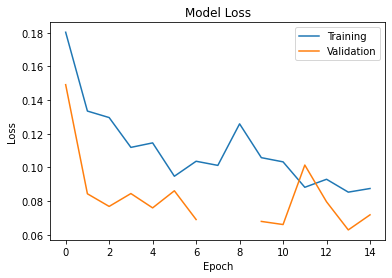

In [ ]:
plt.figure()
plt.plot(h_callback.history['loss'])
plt.plot(h_callback.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Comparing the depth predictions to the truth shows that this model performance also has some pros and cons. It appears that this model does a worse job at capturing sharp edges as most of the depth predictions appear as blobs. However it does appear to do a better job with busy images such as the chairs where it accurately predicts the top to be further away.

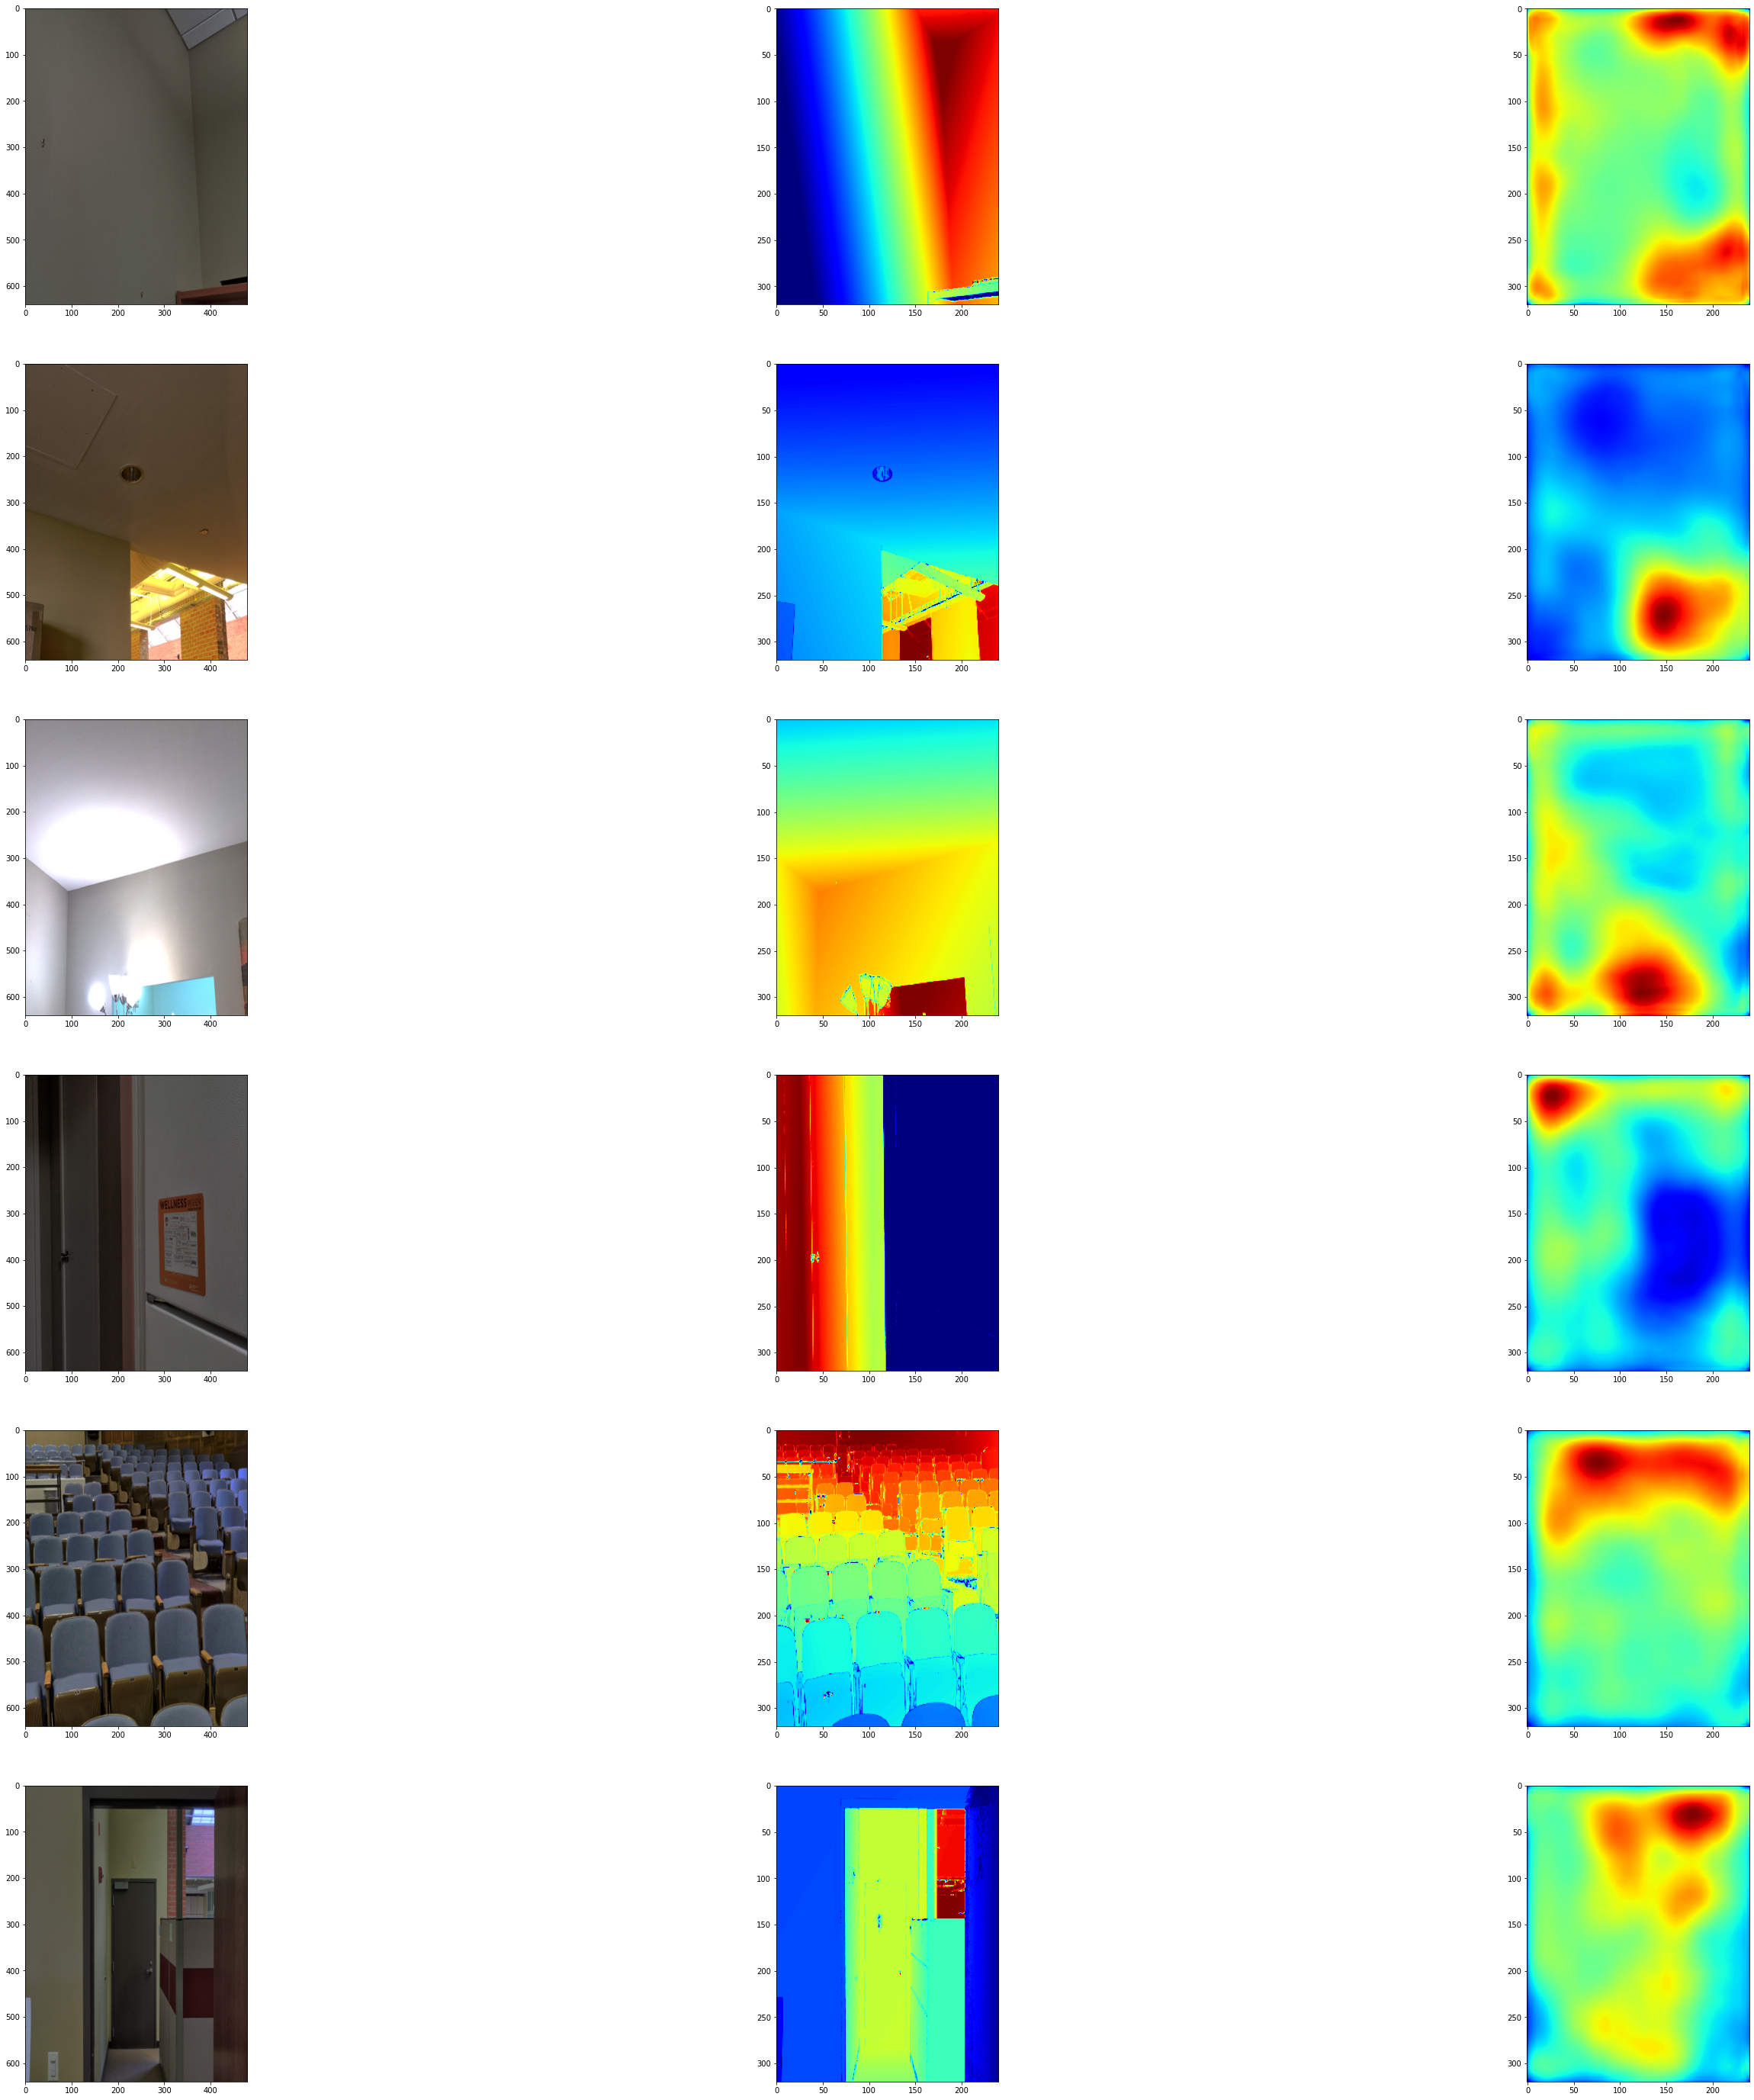

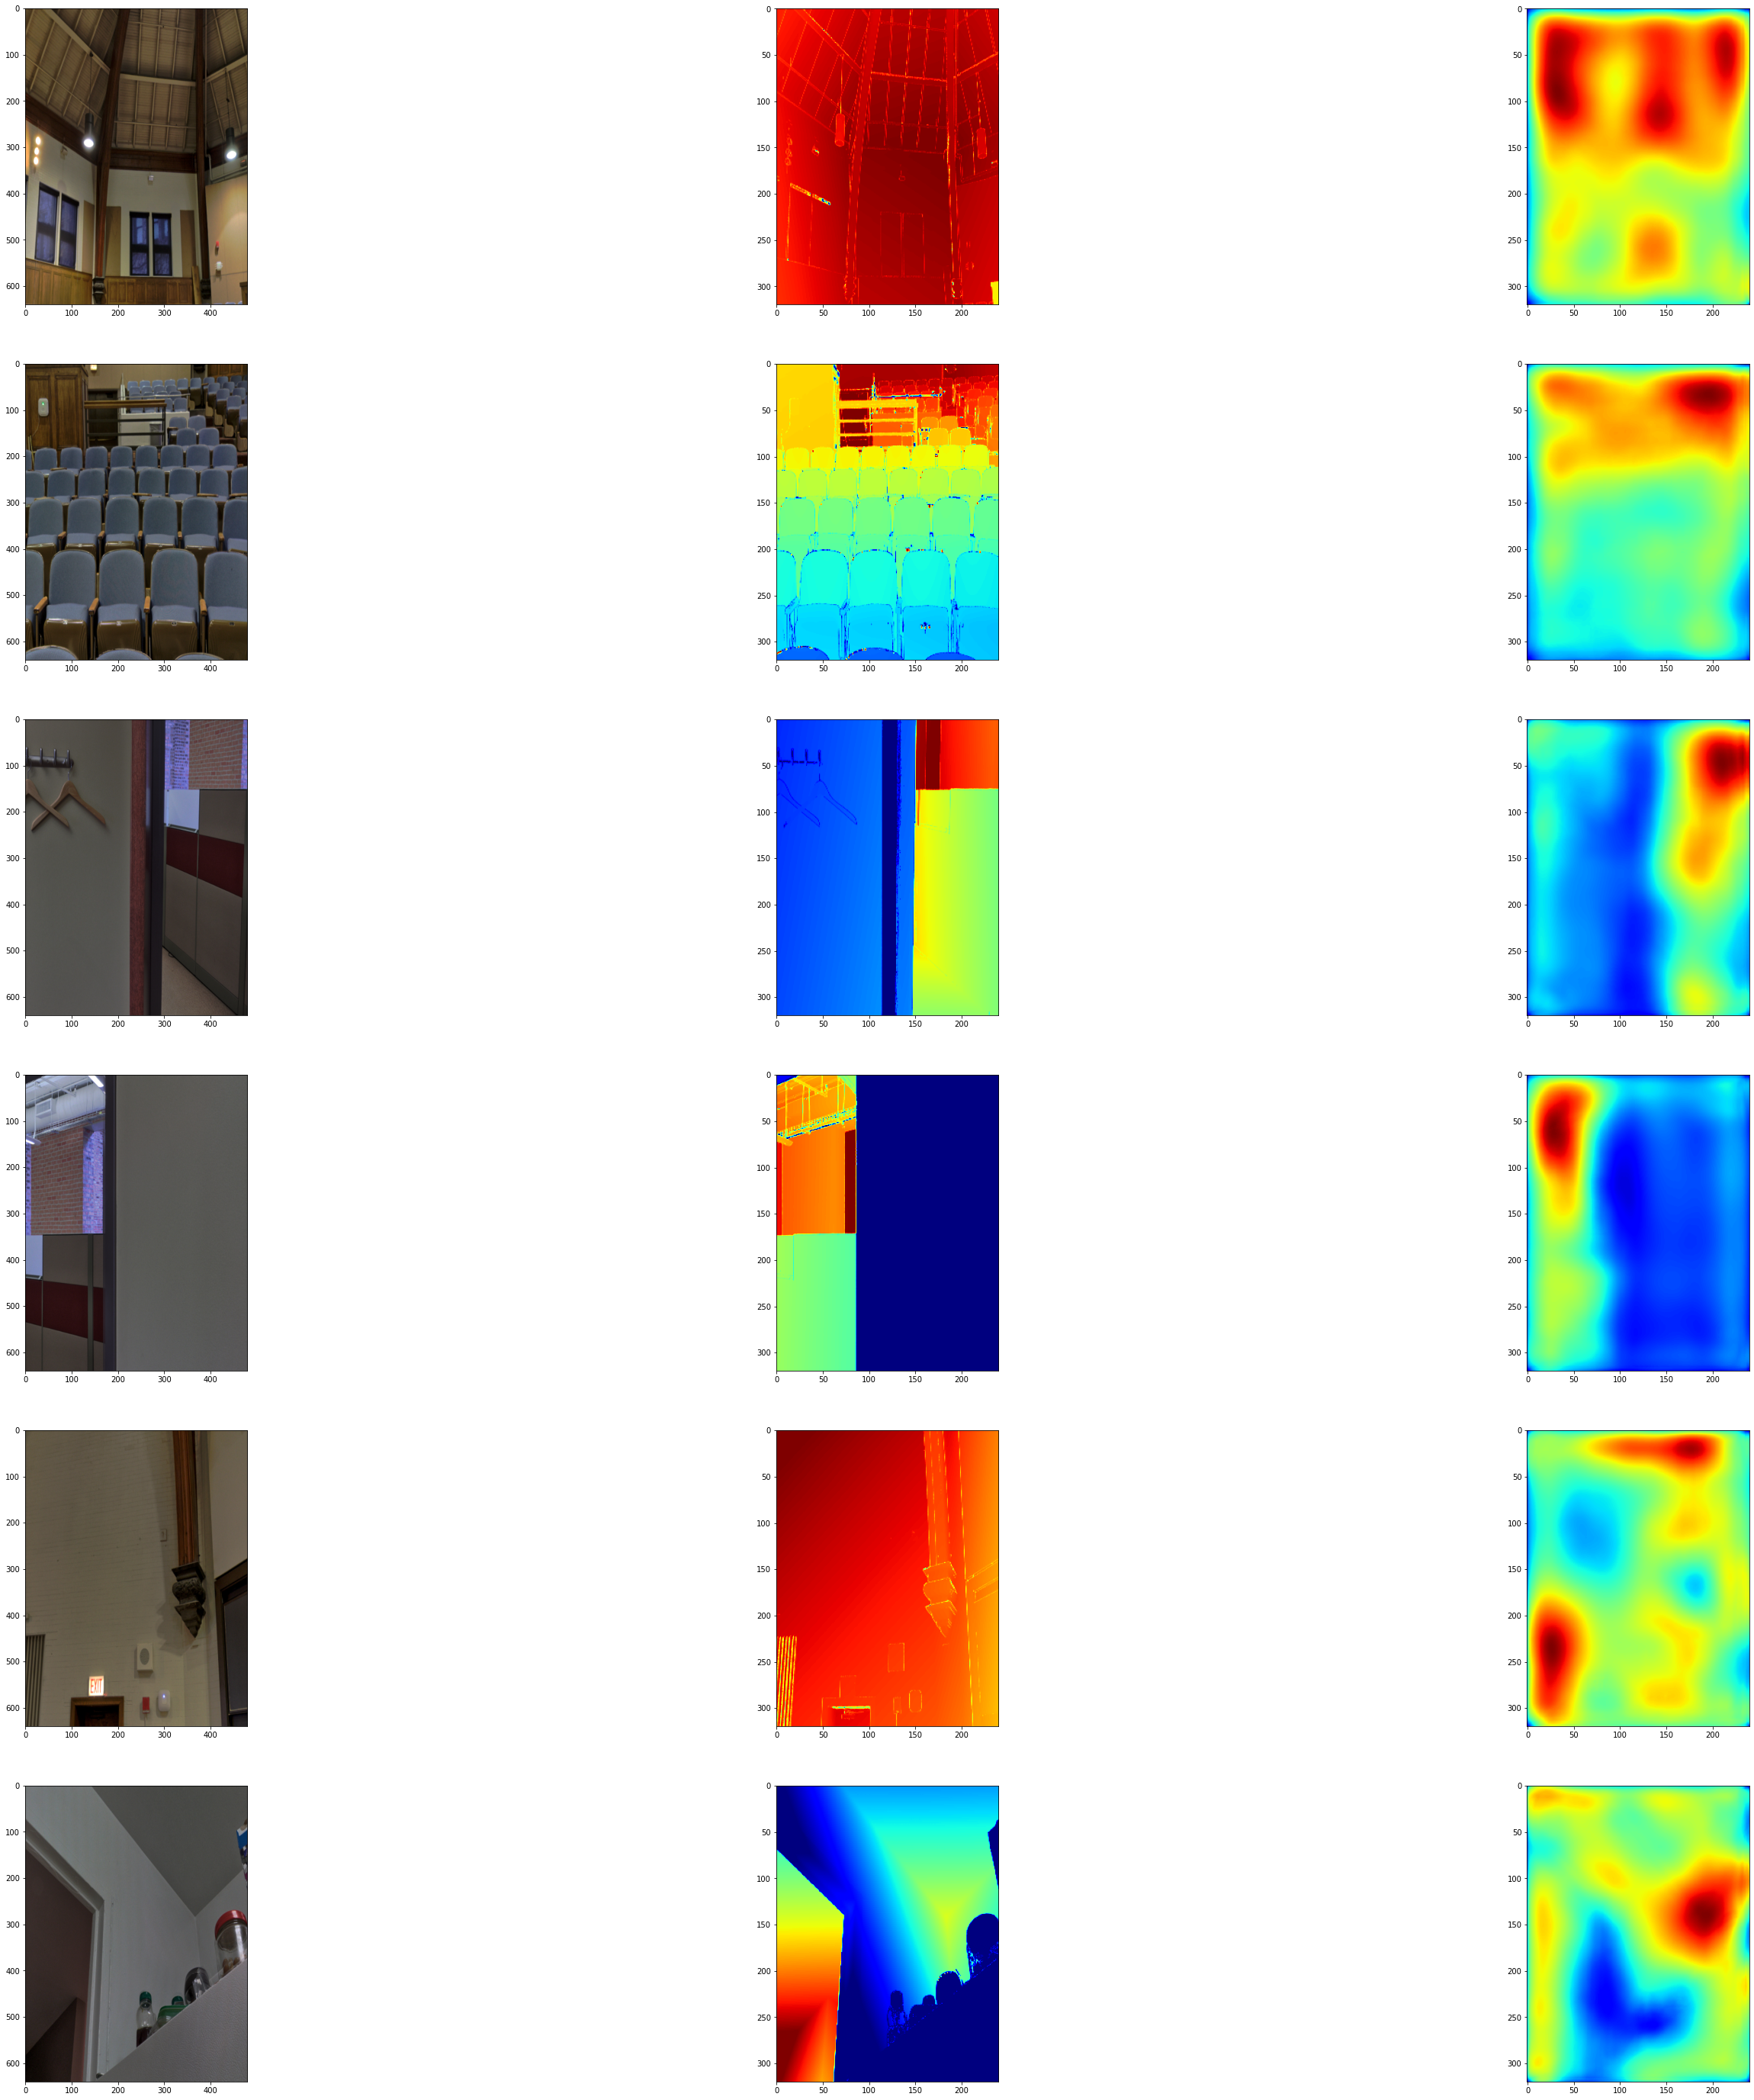

In [ ]:
test_loader = next(
    iter(
        DataGenerator(
            data=df[265:].reset_index(drop="true"), batch_size=6, dim1=(HEIGHT1, WIDTH1), dim2=(HEIGHT2, WIDTH2)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)

test_loader = next(
    iter(
        DataGenerator(
            data=df[300:].reset_index(drop="true"), batch_size=6, dim1=(HEIGHT1, WIDTH1), dim2=(HEIGHT2, WIDTH2)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)

# Summary

In conclusion the pre-trained model does appear to reach a low loss value faster than the model without a pre-trained encoder. However it is not immediately obvious which model is better. The other model appears to do a better job at more accurately portraying the shapes of images along with the depth, however this model appears to do a better job with images that have a lot of objects in them such as the predictions in the rooms filled with chairs.
 
This was also my first time working with models defined via subclassing and I found it a little more difficult as you cannot plot model architecture or save models in the same way as functionally defined models. However working with these models was helpful in learning more about object-oriented programming as I don't have too much prior experience with it.
